In [4]:
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd 
import numpy as np
import requests

In [5]:
# Import data #
r=requests.get('https://www.nomisweb.co.uk/api/v01/dataset/NM_31_1.jsonstat.json')
with open('uk_data.json') as uk_data:
    data= r.json()

In [8]:
# Initialize dictionary
l={}
#separate values 
value=data['value']
# Initialize counter
a=0
## Populate all values of a 37x4x3x25x2 array (time      37 years 
#                                             geography 4 regions 
#                                             sex       3 classes
#                                             age       25 classes
#                                             measure   2 classes )
# This array will be of length 22,200
# The counter serves as the index for which to search through values list (length 22,200)
# for example at a=1, we are indexing   time = 0      (1981)  
#                                       geography = 0 (Wales)
#                                       sex = 0       (Males) 
#                                       age = 0       (All Ages) 
#                                       measures = 0  (Values)
# We would then associate the corresponding index value in our values list (length 22,200)


for b,c in data['dimension']['time']['category']['label'].items():
    for d,e in data['dimension']['geography']['category']['label'].items():
        for f,g in data['dimension']['sex']['category']['label'].items():
            for h,i in data['dimension']['age']['category']['label'].items():
                for j,k in data['dimension']['measures']['category']['label'].items():   
                    a+=1
                    ##counter serves as the index for which to search values list (length 22,200)
                    l[a]=c,e,g,i,k,value[a-1]        


df= pd.DataFrame.from_dict(l,orient='index')

df.columns=['Year','Region','Sex','Age','Measure','Value']


In [12]:
df.head()

,Year,Region,Sex,Age,Measure,Value
1,1981,Wales,Male,All ages,Value,1365100.0
2,1981,Wales,Male,All ages,Percent,100.0
3,1981,Wales,Male,Aged under 1 year,Value,18300.0
4,1981,Wales,Male,Aged under 1 year,Percent,1.3
5,1981,Wales,Male,Aged 1 - 4 years,Value,70200.0


In [13]:
## do the same operation as above to get index values to aid in easy numeric filtering, 
#   eg: age==0 rather than age=='All Ages'
## these two steps could possibly be combined for efficiency (not explored)
m={}
a=0
for b,c in data['dimension']['time']['category']['index'].items():
    for d,e in data['dimension']['geography']['category']['index'].items():
        for f,g in data['dimension']['sex']['category']['index'].items():
            for h,i in data['dimension']['age']['category']['index'].items():
                for j,k in data['dimension']['measures']['category']['index'].items():   
                    a+=1
                    
                    m[a]=c,e,g,i,k,value[a-1]        
                    
df2= pd.DataFrame.from_dict(m,orient='index')
df2.columns=['Year_key','Region_key','Sex_key','Age_key','Measure_key','Value2']
# merge both datasets 
df3=pd.merge(df,df2, left_index=True,right_index=True)
df3['Value2']=df3['Value2'].astype(float)
# cleaning up workspace
del a,b,c,d,e,f,g,h,i,j,k,l

In [15]:
#table showing male,female and total population in columns, per UK region in rows with UK total
## for 2017, the most recent year of data in the dataset


##filter to necessary data, age=All Ages, Measure = Value, Year = 2017 
df4=df3[(df3['Year_key']==36) & (df3['Age_key']==0) &  (df3['Measure_key']==0) ]
#females only data
females=df4[df4['Sex_key']==1]
females=females[['Region','Value']]
#males only data
males=df4[df4['Sex_key']==0]
males=males[['Region','Value']]
#totals 
total=df4[df4['Sex_key']==2]
total=total[['Region','Value']]

#merge males,females and total into one table and rename columns
mytable = pd.merge(males,females,on='Region')
mytable=pd.merge(mytable,total,on='Region')
mytable.columns=['Region','Males','Females','Total']

#transpose to calculate UK Total
result = mytable.T
result=result.drop(['Region'])
##calculate UK total - it will be sum of England&Wales, Scotland and Northern Ireland minus Wales
result[4]= result[1]+ result[2]+result[3]-result[0]
result=result.T


Table1=mytable.merge(result,how='outer',left_index=True, right_index=True)
##cleaning for final presentation
Table1.drop(['Males_x','Females_x','Total_x'],inplace=True, axis=1)
Table1.columns=['Region','Males','Females','Total']
Table1.iloc[4,0]='UK Total'
Table1.Males=Table1.Males.astype(float)
Table1.Females=Table1.Females.astype(float)
Table1.Total=Table1.Total.astype(float)
#Present output
Table1

,Region,Males,Females,Total
0,Wales,1540200.0,1585000.0,3125200.0
1,Scotland,2640300.0,2784500.0,5424800.0
2,Northern Ireland,920200.0,950600.0,1870800.0
3,England and Wales,29021300.0,29723300.0,58744600.0
4,UK Total,31041600.0,31873400.0,62915000.0


In [18]:

## Data exploration 

##Population pyramids 
def pop_pyramid(Region_key,Year_key):
#    this function returns a population period for the specfied Region and Year 
#  
#    inputs: Region: Specify one of 4 regions: Scotland, Wales, England&Wales or Northern Ireland
#            Year: specify the year to see population statistics for a specific year between 1981-2017
#    
#    output: matplotlib population pyramid
    
    pyramid_data=df3[ (df3['Age_key'] <20) & (df3['Age_key'] !=0) &  (df3['Measure_key']==0) 
            & (df3['Region_key']==Region_key ) &  (df3['Sex_key']!=2) & (df3['Year_key']==Year_key) ]
    
    hist= pyramid_data.loc[:,:'Value']
    hist_m= hist[hist['Sex']=='Male']
    hist_f = hist[hist['Sex']=='Female']  
    age_groups = tuple(hist_m['Age'])
    y = np.arange(len(age_groups))
    malesW = hist_m['Value']
    femalesW = hist_f['Value']
    
    fig, axes = plt.subplots(ncols=2, sharey=True)
    axes[0].barh(y, malesW, align='center', color='blue')
    axes[0].set(title='Males')
    axes[1].barh(y, femalesW, align='center', color='blue')
    axes[1].set(title='Females')
    axes[0].invert_xaxis()
    plt.ylabel('Age Groups')
    return plt.show()



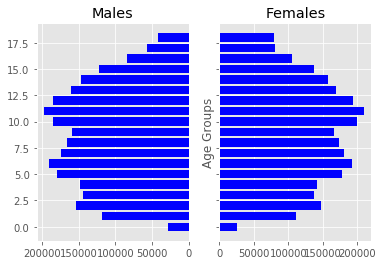

In [51]:
#2017, Scotland
pop_pyramid(1,36)

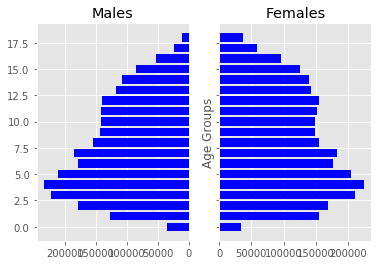

In [25]:
#1981, Scotland
pop_pyramid(1,0)

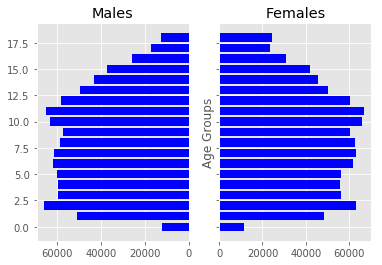

In [62]:
#2017, Northern Ireland
pop_pyramid(2,36)

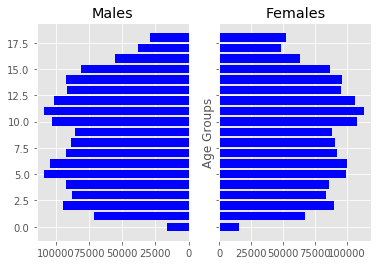

In [63]:
#1981, Wales
pop_pyramid(0,36)

In [49]:

def timeseries(Region_key):
#    this function returns a time series chart for the specfied Region(1981-2017)
#  
#    inputs: Region: Specify one of 4 regions: Scotland, Wales, England&Wales or Northern Ireland

#    output: matplotlib chart
    
    ##time series population data for Wales
    timeseries= df3[ (df3['Age_key']==0) &  (df3['Measure_key']==0) 
                & (df3['Region_key']==Region_key ) &  (df3['Sex_key']==2) ]
    data = (timeseries['Value'])
    data.plot(figsize=(15,6))
    return plt.show()


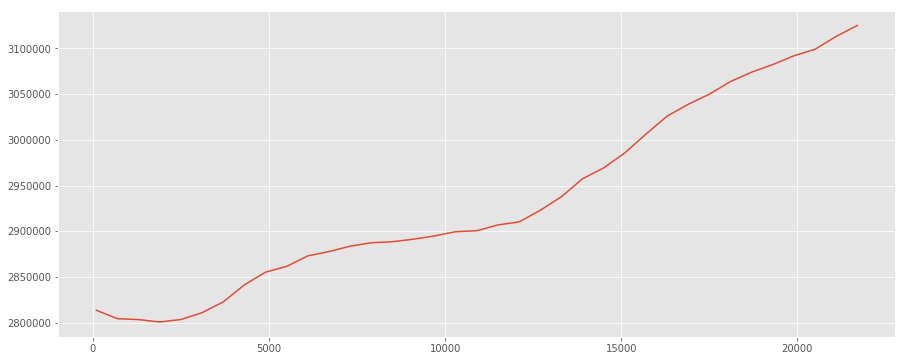

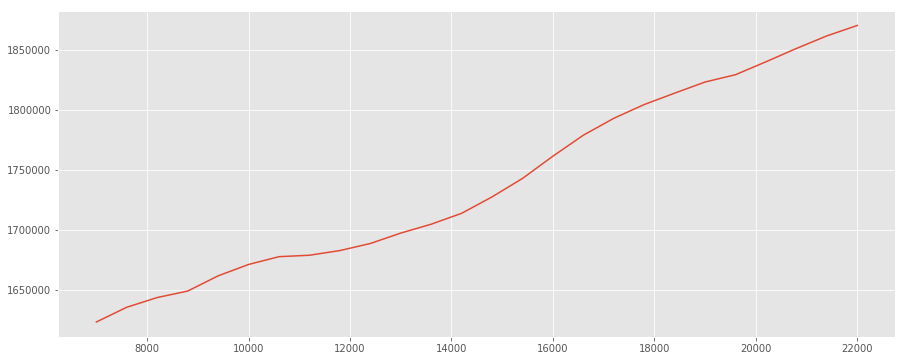

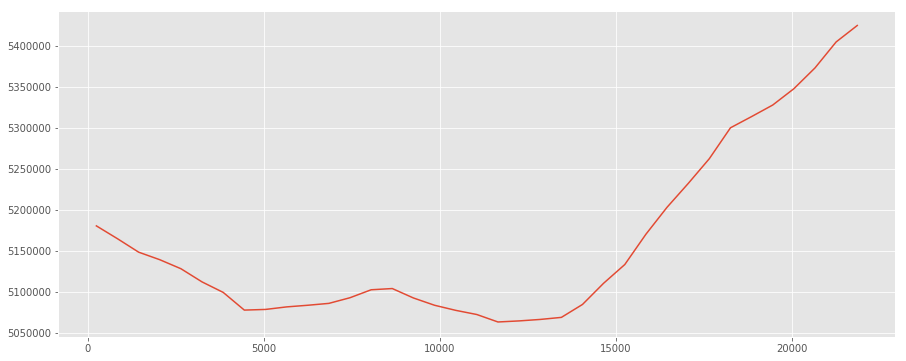

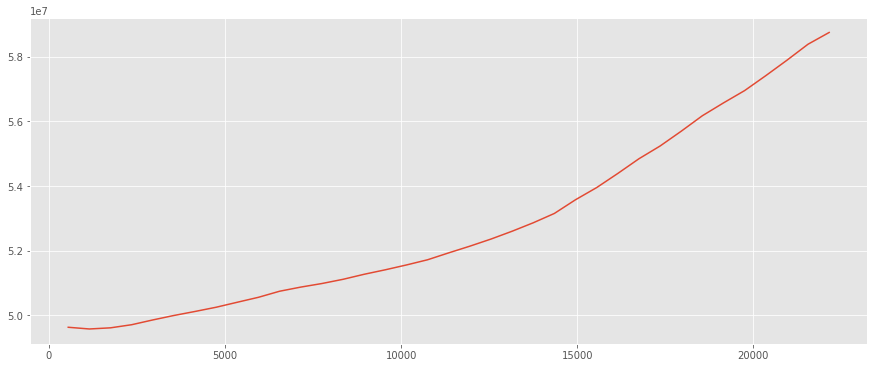

In [50]:
#Wales
timeseries(0)
#Northern Ireland
timeseries(2)
#Scotland
timeseries(1)
#England&Wales
timeseries(3)

In [39]:

##year over year growth
def timeseries_yoy(Region_key):
#    this function returns a yoy pct change time series chart for the specfied Region(1981-2017)
#  
#    inputs: Region: Specify one of 4 regions: Scotland, Wales, England&Wales or Northern Ireland

#    output: matplotlib chart
    
    ##time series population data for Wales
    timeseries= df3[ (df3['Age_key']==0) &  (df3['Measure_key']==0) 
                & (df3['Region_key']==Region_key ) &  (df3['Sex_key']==2) ]
    data = timeseries['Value']
    data.pct_change().plot(figsize=(15,6))
    return plt.show()




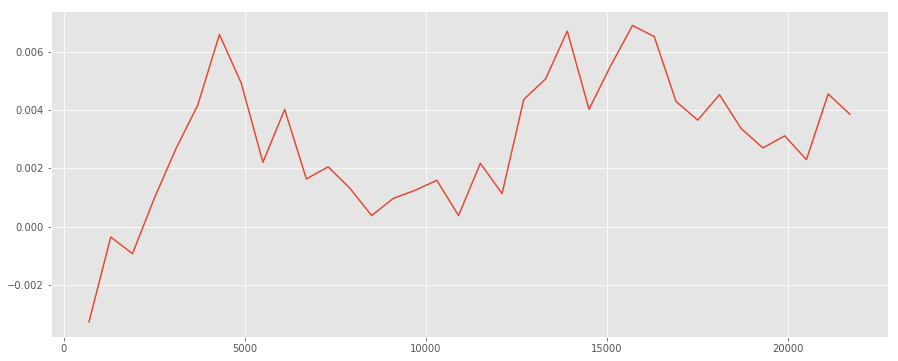

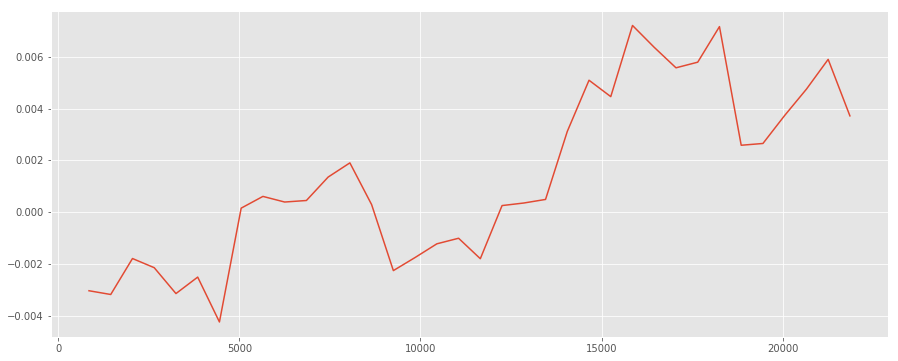

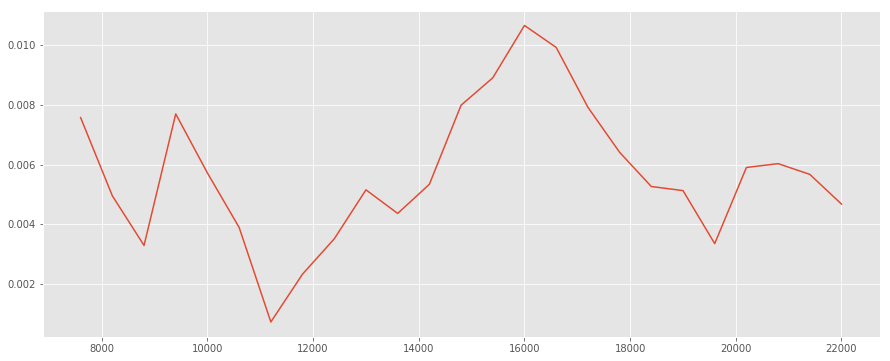

In [41]:
#Wales
timeseries_yoy(0)
#Scotland
timeseries_yoy(1)
#Northern Ireland
timeseries_yoy(2)